In [36]:
import fxcmpy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyti.exponential_moving_average import exponential_moving_average as ema
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_rows = 4000
from trading import tradeFXCM
import algorithm 
import Backtesting 
from importlib import reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
con = fxcmpy.fxcmpy(config_file='fxcm.cfg')

In [3]:
all_frequency = ['m1','m5', 'm15', 'm30', 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'D1', 'W1']
all_instrument = ['EUR/USD']

# BACKTESTING

calcul profit
gain : -0.050103


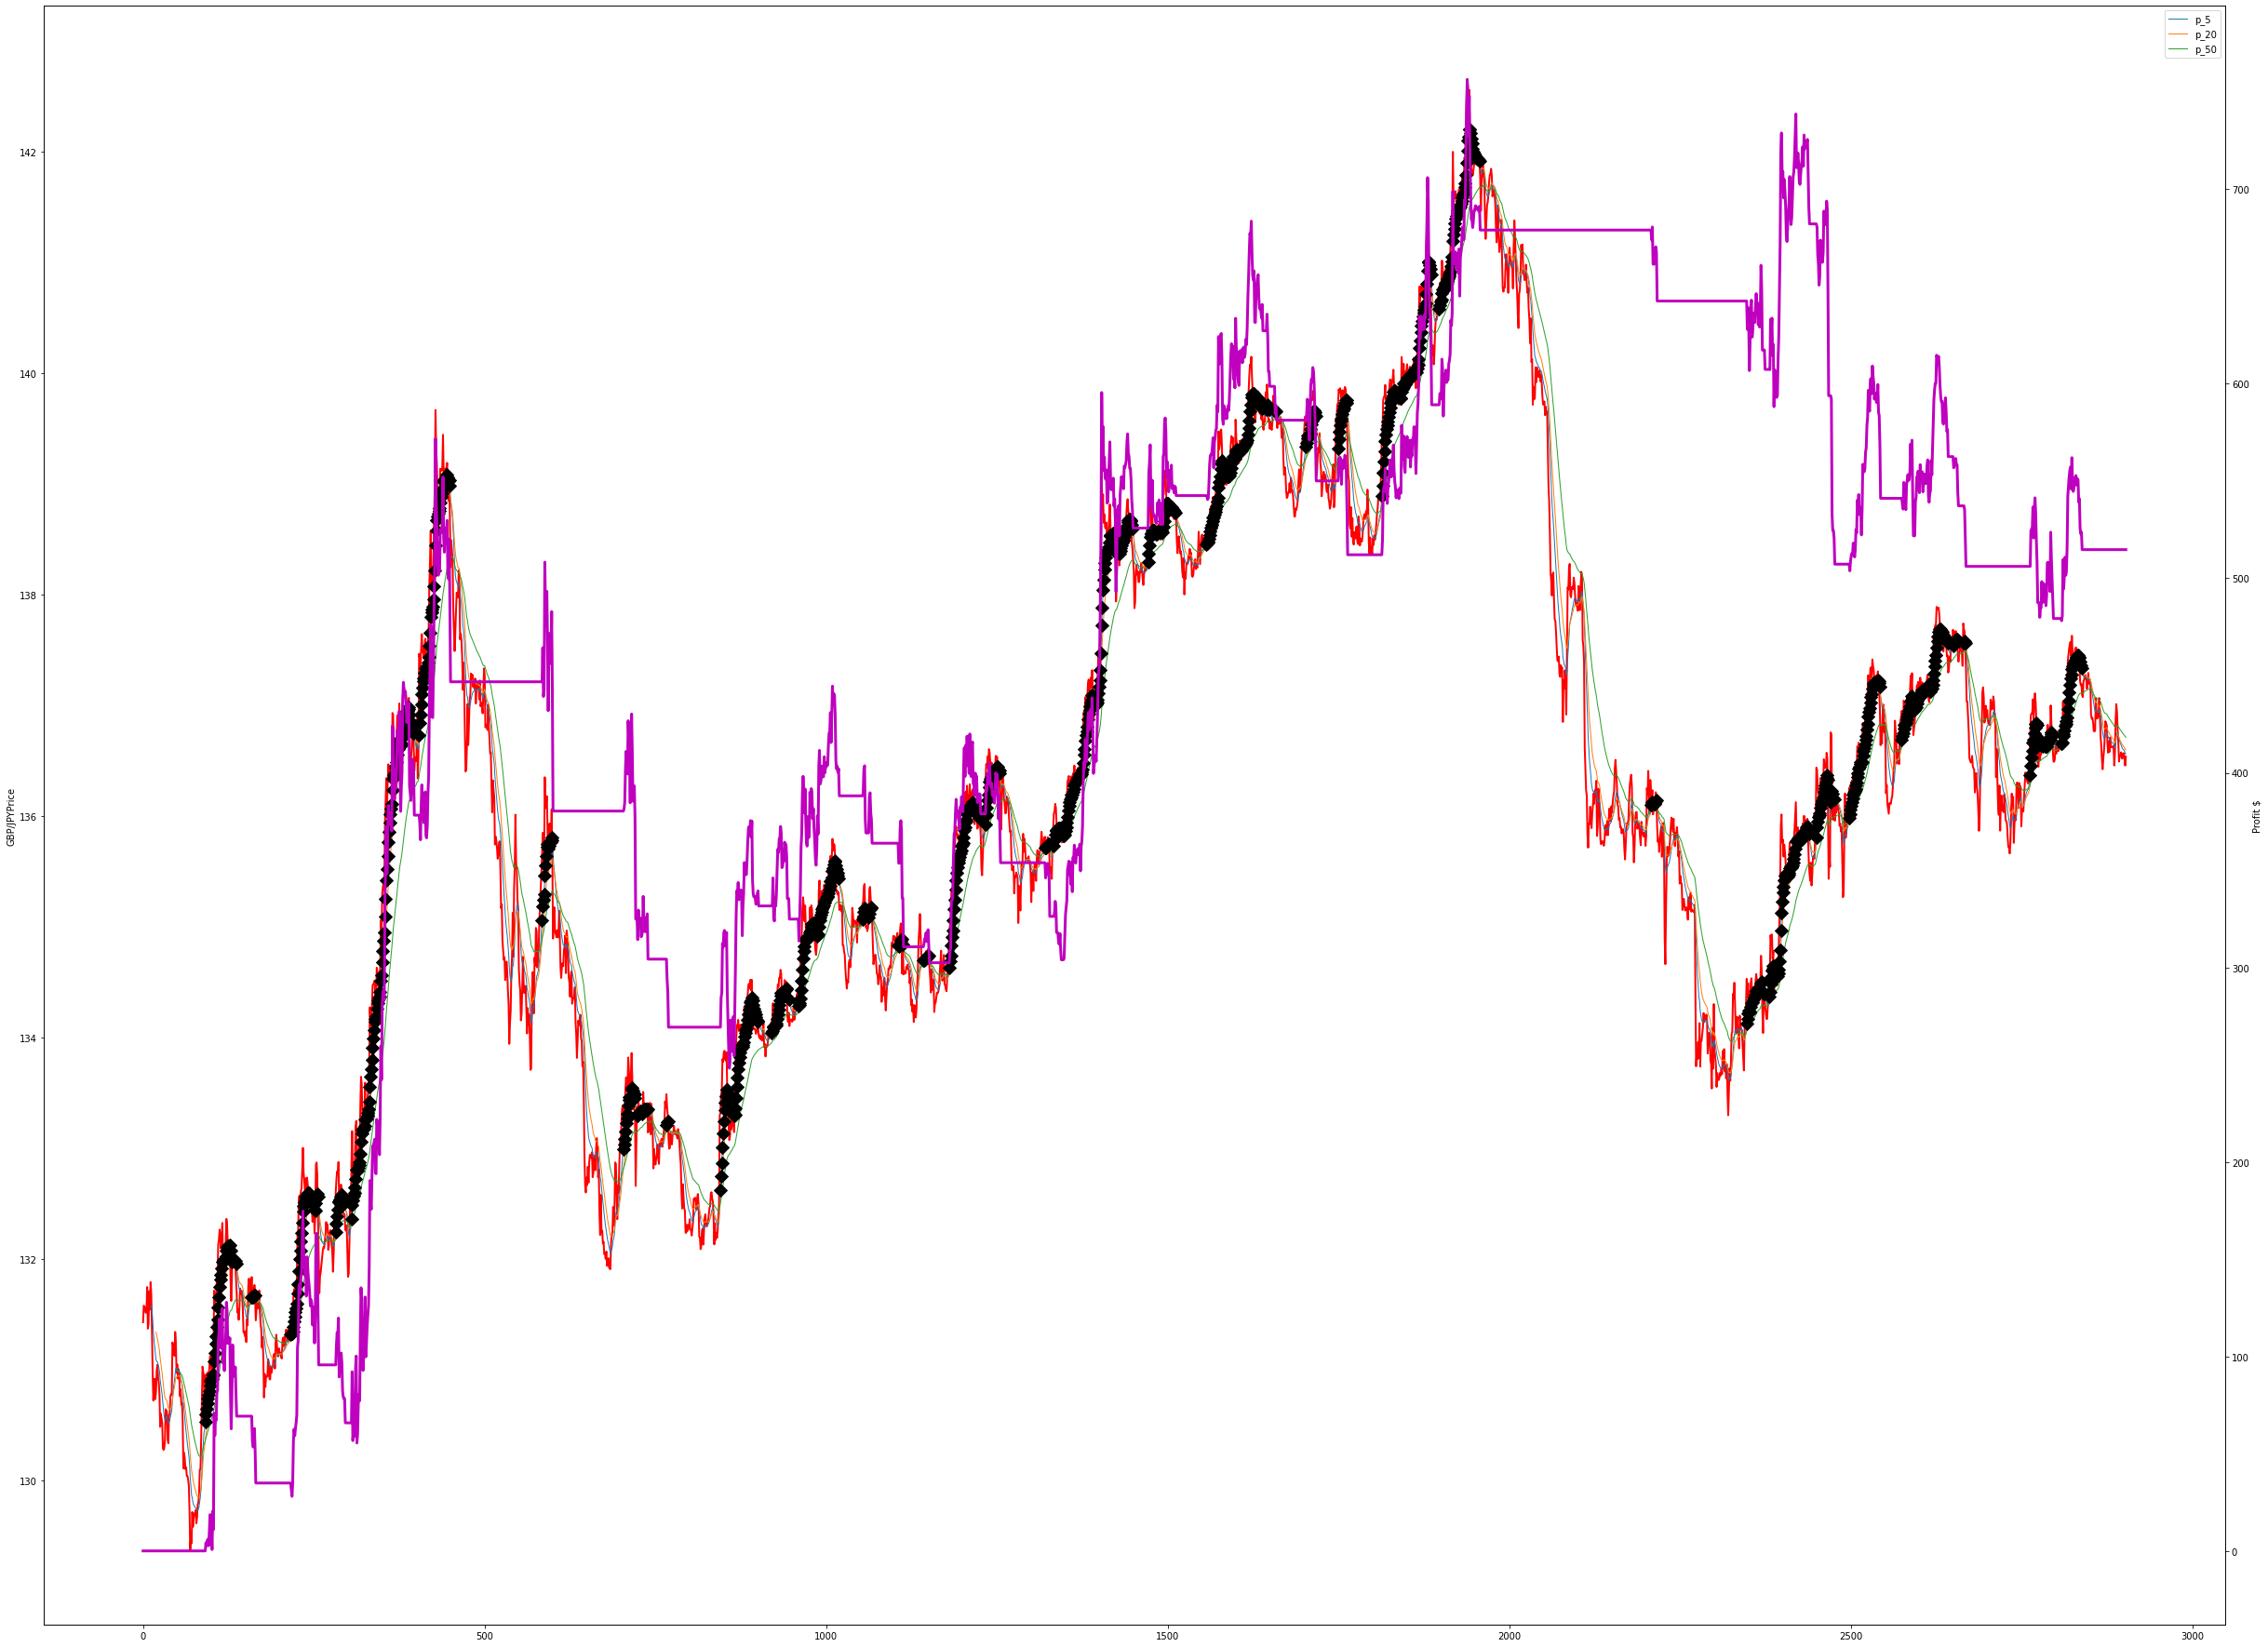

In [32]:
start = '2020-05-13 00:00:00'
end = '2020-10-27 00:00:00'
test = BacktestingFXCM('GBP/JPY', 'H1', start, end, con)
test.calculPositionEMAv()
test.calculProfit()
test.plotting()
print("gain : %f" %testUSD.result['total'].iloc[-1])

In [68]:
reload(Backtesting)
from Backtesting import BacktestingFXCM
reload(algorithm)
from algorithm import *

14437
14463
14437
                       tenkan     kijun   chikou   senkouA   senkouB
date                                                                
2020-10-26 23:56:00  1.180925  1.180965  1.18102  1.180990  1.180935
2020-10-26 23:57:00  1.180930  1.180965  1.18103  1.180990  1.180935
2020-10-26 23:58:00  1.180985  1.180965  1.18104  1.180997  1.180930
2020-10-26 23:59:00  1.180980  1.180965  1.18103  1.181002  1.180930
2020-10-27 00:00:00  1.180980  1.180965  1.18106  1.181010  1.180930
                     askclose  bidclose  askhigh   asklow  askopen
date                                                              
2020-10-26 23:56:00   1.18100   1.18086  1.18102  1.18095  1.18097
2020-10-26 23:57:00   1.18093   1.18079  1.18102  1.18092  1.18100
2020-10-26 23:58:00   1.18091   1.18078  1.18093  1.18087  1.18093
2020-10-26 23:59:00   1.18098   1.18085  1.18099  1.18089  1.18091
2020-10-27 00:00:00   1.18097   1.18085  1.18101  1.18087  1.18098
calcul profit
gain : 0.004395


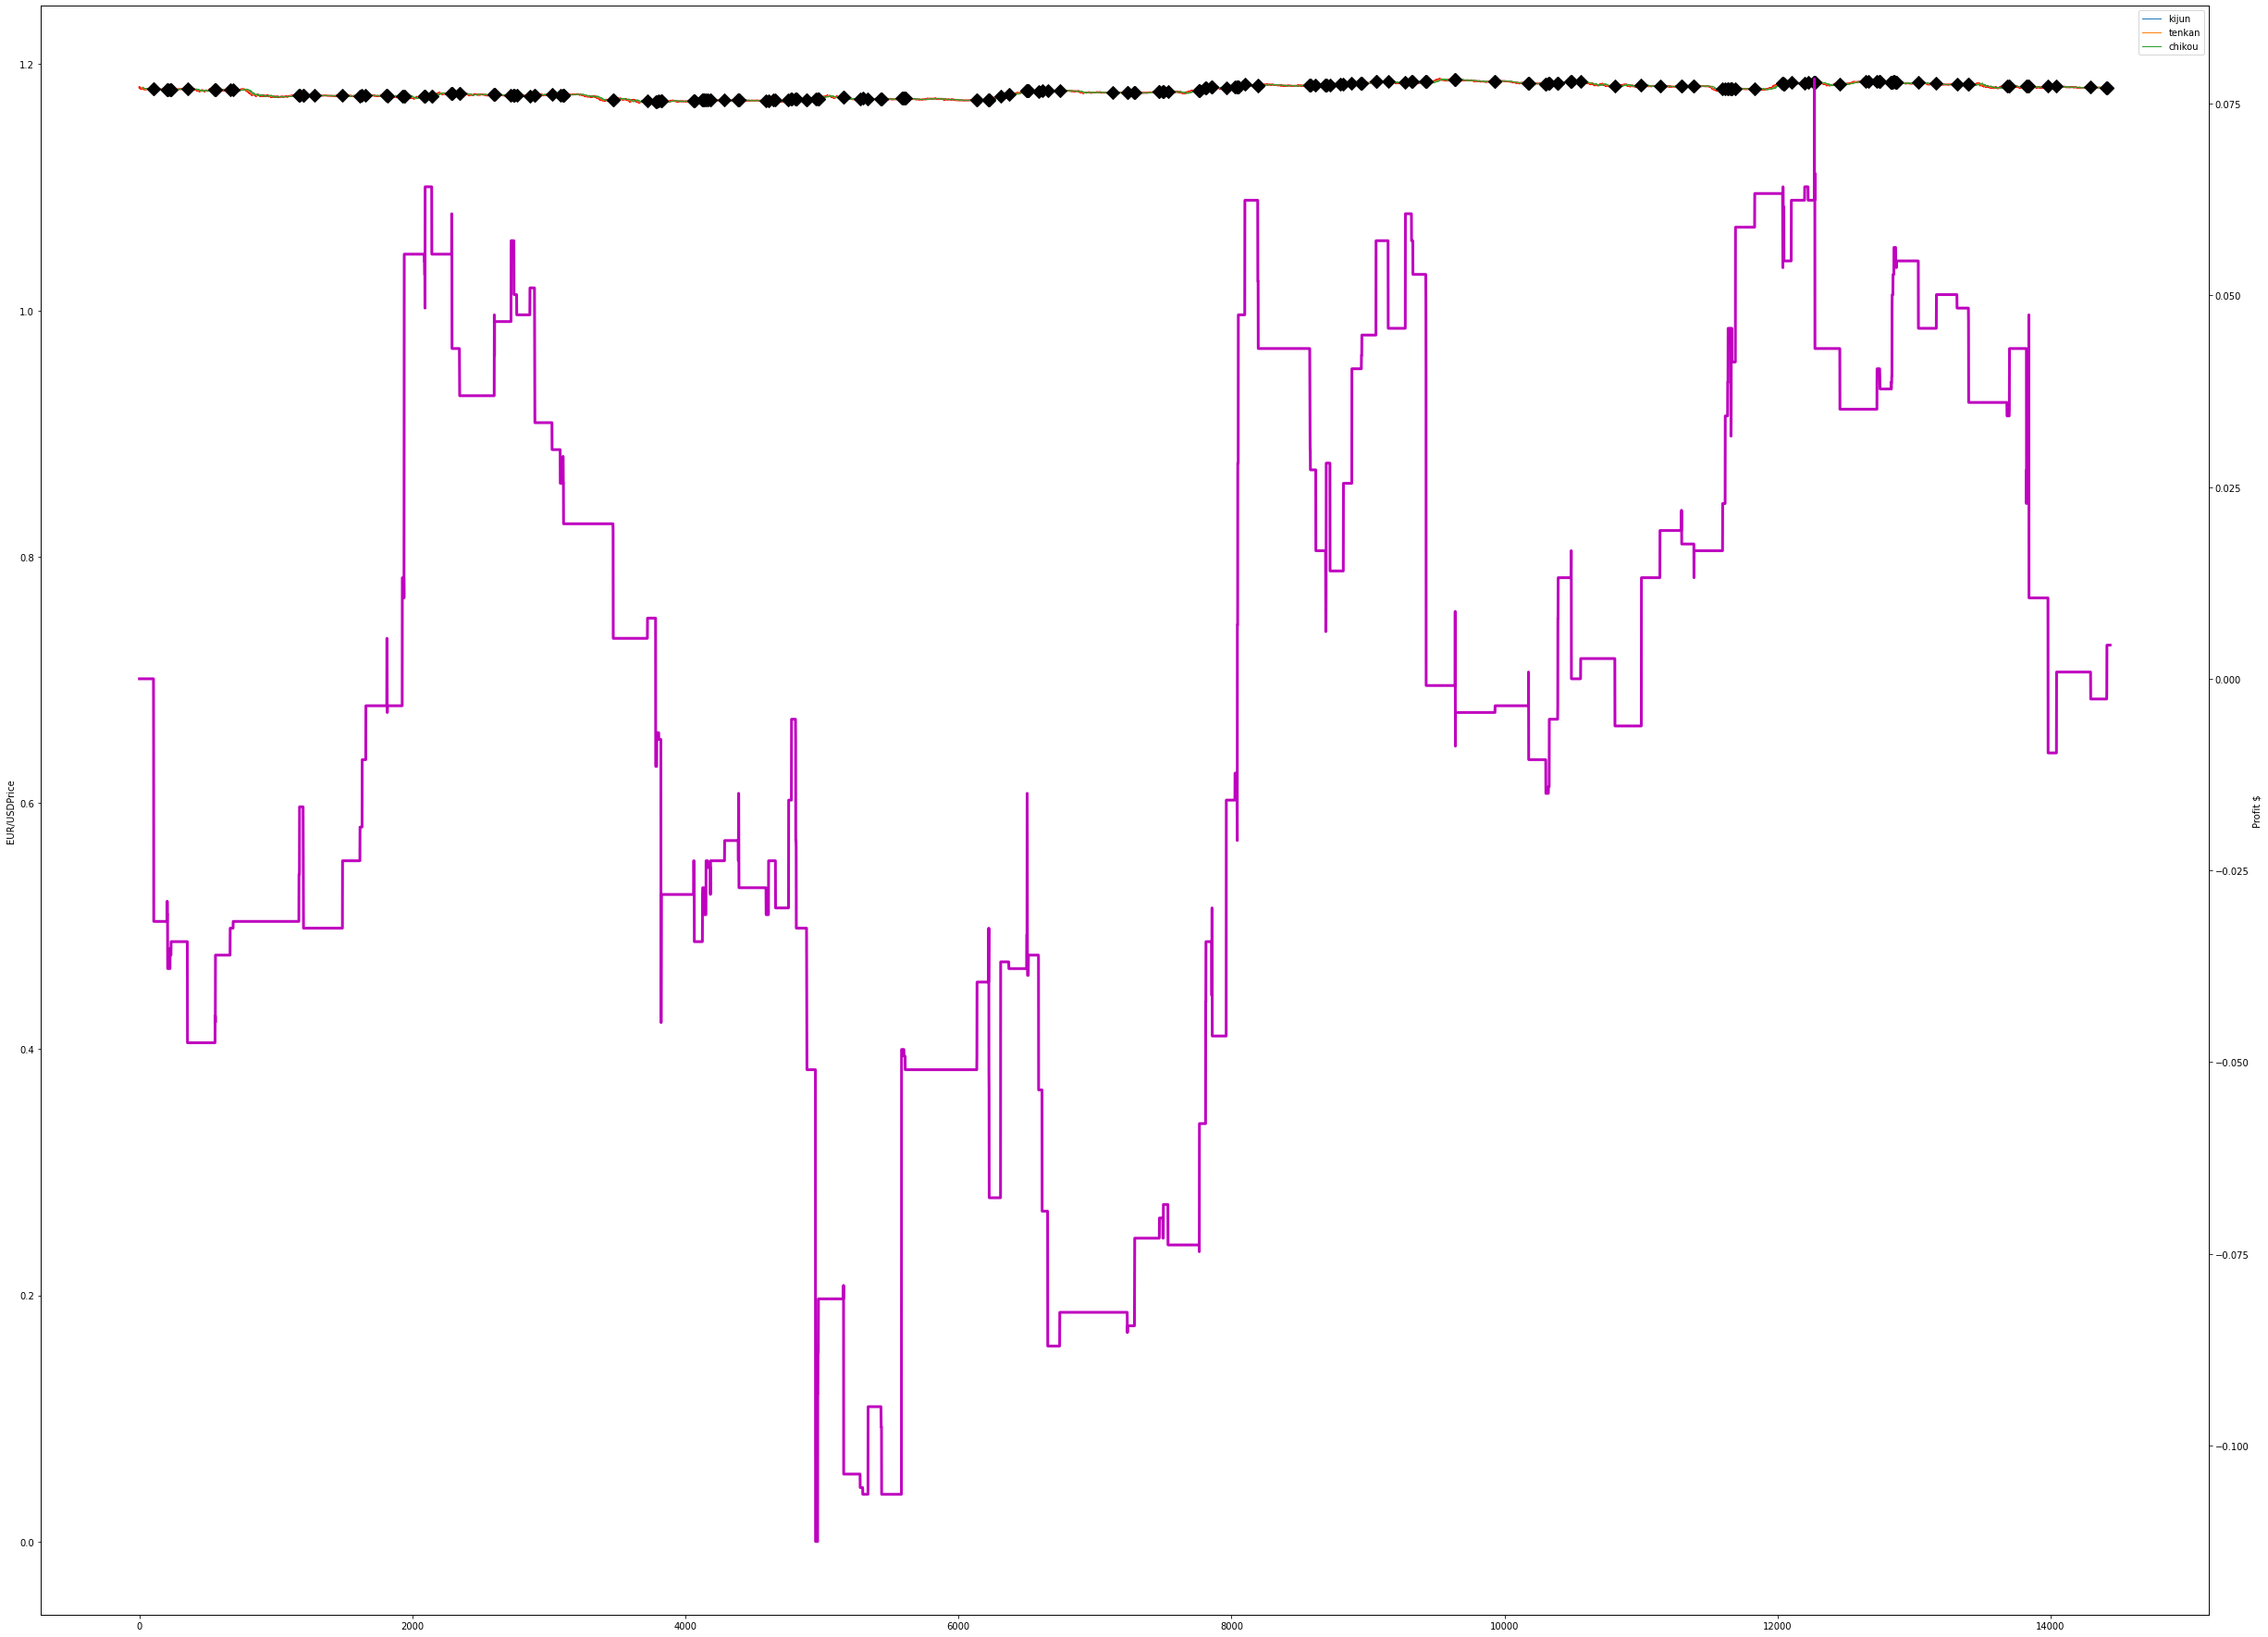

In [74]:
#start = '2019-01-01 00:00:00'
start = '2020-10-13 00:00:00'
end = '2020-10-27 00:00:00'
testUSD = BacktestingFXCM('EUR/USD', 'm1', start, end, con)
#testUSD.calculPositionEMAv()
testUSD.calculPositionIchimoku()
testUSD.calculProfit()
#testUSD.plotting()
testUSD.plottingICHI()
print("gain : %f" %testUSD.result['total'].iloc[-1])

# TRADING

In [ ]:
all_market = []
all_market.append(tradeFXCM('EUR/USD', 'H1', con))

In [ ]:
while 1:
    for market in all_market:
        duration = datetime.datetime.now() - market.time_update
        duration_in_s = duration.total_seconds()
        hours = divmod(duration_in_s, 3600)[0]
        #check one minute
        if market.time_update == 'H1':
            if hours == 1:
                market.update()
            #decisionEMAv(self.data, self.EMAv)

In [ ]:
con.close()